In [1]:
# Dimensionality Reduction
# Principal Component Analysis


import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit


In [2]:
# Finding principal components using single value decomposition
X_centered = X - X.mean(axis = 0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[ : , 0]
c2 = V.T[ : , 1]

In [3]:
W2 = V.T[ : , :2]
X2D = X_centered.dot(W2)
# To project dataset to a d dimensional hyperplane compute dot product of data matrix with the matrix containing
# first d principal components

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_.T

array([[ 0.67857588,  0.72817329],
       [ 0.70073508, -0.6811147 ],
       [ 0.22023881, -0.07646185]])

In [6]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [7]:
pca = PCA()
pca.fit(X)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components=d)



In [8]:
# However we can just use the desired variance ratio

pca = PCA(n_components=0.95)  # This is same
X_reduced = pca.fit_transform(X)

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', as_frame=False)
X_mnist, y_mnist = mnist.data, mnist.target


/Users/tuncer/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
pca = PCA(n_components=0.95)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)

from sklearn.metrics import mean_squared_error
loss = mean_squared_error(X_mnist, X_mnist_recovered)

In [11]:
np.sqrt(loss)

14.738292375263907

In [12]:
# Incremental PCA

from sklearn.decomposition import IncrementalPCA


inc_pca = IncrementalPCA(n_components=154)
for batch in np.array_split(X_mnist, 100):
    inc_pca.partial_fit(batch)
    
inc_pca.transform(X_mnist)

array([[ 122.25500694,  316.23364499,   51.13178161, ...,   79.54978737,
          70.81789108,    9.17132981],
       [1010.49445865,  289.96446993, -576.12081754, ...,   24.44785951,
         -50.0768693 ,   39.40749108],
       [ -58.99599856, -393.69804681,  161.99724511, ...,   56.43654621,
         -87.9226803 ,  -17.8323958 ],
       ...,
       [-271.50686236, -590.07806446, -341.36905325, ...,  -46.64576339,
          35.14735446,  -25.86730048],
       [-310.22486483,  116.72752672, -635.71984162, ...,  -42.34733241,
         -46.03059498,  -19.6249888 ],
       [1058.86192623,   83.39244069, -731.34206351, ...,  -54.49489283,
         -89.19509602,  -24.05562367]])

In [13]:
# Randomized PCA

rnd_pca = PCA(n_components=154, svd_solver="randomized")

X_reduced = rnd_pca.fit_transform(X_mnist)


In [14]:
# Kernel PCA

from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

kernel_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
kernel_pca.fit(X_swiss)



KernelPCA(gamma=0.04, kernel='rbf', n_components=2, random_state=42)

In [15]:
# Selecting Kernel
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


X, y = fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


clf = Pipeline([("kPCA", KernelPCA(n_components=2)),
               ("log_reg", LogisticRegression()),
               ])


param_grid = [{"kPCA__gamma" : np.linspace(0.03, 0.05, 10),
              "kPCA__kernel": ["rbf", "sigmoid", "linear"]}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X_train[ :10000], y_train[ :10000])


/Users/tuncer/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/Users/tuncer/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

/Users/tuncer/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tuncer/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kPCA', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kPCA__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kPCA__kernel': ['rbf', 'sigmoid', 'linear']}])

In [16]:
grid_search.best_params_

{'kPCA__gamma': 0.05, 'kPCA__kernel': 'linear'}

In [17]:
results = grid_search.cv_results_

for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(mean_score, params)

0.11220000224377565 {'kPCA__gamma': 0.03, 'kPCA__kernel': 'rbf'}
0.11220000224377565 {'kPCA__gamma': 0.03, 'kPCA__kernel': 'sigmoid'}
0.42319990847315087 {'kPCA__gamma': 0.03, 'kPCA__kernel': 'linear'}
0.11220000224377565 {'kPCA__gamma': 0.03222222222222222, 'kPCA__kernel': 'rbf'}
0.11220000224377565 {'kPCA__gamma': 0.03222222222222222, 'kPCA__kernel': 'sigmoid'}
0.42319990847315087 {'kPCA__gamma': 0.03222222222222222, 'kPCA__kernel': 'linear'}
0.11220000224377565 {'kPCA__gamma': 0.034444444444444444, 'kPCA__kernel': 'rbf'}
0.11220000224377565 {'kPCA__gamma': 0.034444444444444444, 'kPCA__kernel': 'sigmoid'}
0.42319990847315087 {'kPCA__gamma': 0.034444444444444444, 'kPCA__kernel': 'linear'}
0.11220000224377565 {'kPCA__gamma': 0.03666666666666667, 'kPCA__kernel': 'rbf'}
0.11220000224377565 {'kPCA__gamma': 0.03666666666666667, 'kPCA__kernel': 'sigmoid'}
0.42319990847315087 {'kPCA__gamma': 0.03666666666666667, 'kPCA__kernel': 'linear'}
0.11220000224377565 {'kPCA__gamma': 0.0388888888888888

In [18]:
# Reconstruction Preimage Error

rbf_pca = KernelPCA(n_components = 2, kernel = "linear", gamma = 0.05, fit_inverse_transform = True)

X_reduced = rbf_pca.fit_transform(X_swiss)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X_swiss, X_preimage)

51.58463490231256

In [21]:
# Locally Linear Embedding

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, random_state=42)


X_reduced = lle.fit_transform(X_swiss)


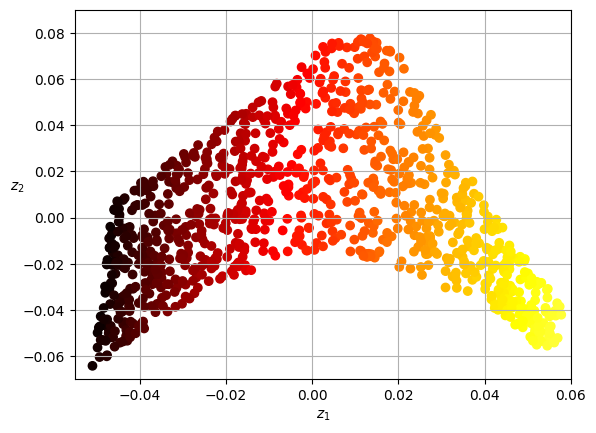

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.show()
